In [ ]:
#Bag-of-Visual-Wordsimport

import numpy as np 
import os
import cv2
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from matplotlib import pyplot as plt
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.metrics.pairwise import chi2_kernel
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from skimage.io import imread
from skimage.color import rgb2gray

In [ ]:
!pip install opencv-python==3.4.2.17
!pip install opencv-contrib-python==3.4.2.17

In [ ]:
def getFiles(train, path):
    images = []
    count = 0
    for folder in os.listdir(path):
        for file in  os.listdir(path +'/'+ folder):
            images.append(path+'/' + folder  + '/'+  file)

    if(train is True):
        np.random.shuffle(images)
    
    return images

In [ ]:
def getDescriptorsSift(sift, img):
    kp, des = sift.detectAndCompute(img, None)
    return des

def getDescriptorsSurf(surf, img):
    kp, des = surf.detectAndCompute(img, None)
    return des

def getDescriptorsHarris(img):
    gray = np.float32(rgb2gray(img))
    dst=cv2.cornerHarris(gray,4,3,0.04)
    dst = cv2.dilate(dst,None)
    dessi, des = cv2.threshold(dst,0.01*dst.max(),255,0)
    return des

def readImage(img_path):
    img = cv2.imread(img_path, 0)
    return cv2.resize(img,(150,150))

def vstackDescriptors(descriptor_list):
    descriptors = np.array(descriptor_list[0])
    for descriptor in descriptor_list[1:]:
        descriptors = np.vstack((descriptors, descriptor)) 
    return descriptors

In [ ]:

def clusterDescriptors(descriptors, no_clusters):
    kmeans = KMeans(n_clusters = no_clusters).fit(descriptors)
    return kmeans

def extractFeatures(kmeans, descriptor_list, image_count, no_clusters, method):
    im_features = np.array([np.zeros(no_clusters) for i in range(image_count)])
    for i in range(image_count):
        for j in range(len(descriptor_list[i])):
            feature = descriptor_list[i][j]

            if(method=='sift'):
                feature = feature.reshape(1, 128) 
            elif(method=='surf'):
                feature = feature.reshape(1, 64)
            else:
                feature = feature.reshape(1, 150)

            idx = kmeans.predict(feature)
            im_features[i][idx] += 1

    return im_features

def normalizeFeatures(scale, features):
    return scale.transform(features)

def plotHistogram(im_features, no_clusters):
    x_scalar = np.arange(no_clusters)
    y_scalar = np.array([abs(np.sum(im_features[:,h], dtype=np.int32)) for h in range(no_clusters)])

    plt.bar(x_scalar, y_scalar)
    plt.xlabel("Visual Word Index")
    plt.ylabel("Frequency")
    plt.title("Complete Vocabulary Generated")
    plt.xticks(x_scalar + 0.4, x_scalar)
    plt.show()

def svcParamSelection(X, y, kernel, nfolds):
    Cs = [0.5, 0.1, 0.15, 0.2, 0.3]
    gammas = [0.1, 0.11, 0.095, 0.105]
    param_grid = {'C': Cs, 'gamma' : gammas}
    grid_search = GridSearchCV(SVC(kernel=kernel), param_grid, cv=nfolds)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

def findSVM(im_features, train_labels, kernel):
    features = im_features
    if(kernel == "precomputed"):
      features = np.dot(im_features, im_features.T)
    
    params = svcParamSelection(features, train_labels, kernel, 5)
    C_param, gamma_param = params.get("C"), params.get("gamma")
    print(C_param, gamma_param)
    class_weight = {
        0: (807 / (7 * 140)),
        1: (807 / (7 * 140)),
        2: (807 / (7 * 133)),
        3: (807 / (7 * 70)),
        4: (807 / (7 * 42)),
        5: (807 / (7 * 140)),
        6: (807 / (7 * 142)) 
    }
  
    svm = SVC(kernel = kernel, C =  C_param, gamma = gamma_param, class_weight = class_weight)
    svm.fit(features, train_labels)
    return svm

def plotConfusionMatrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

def plotConfusions(true, predictions):
    np.set_printoptions(precision=2)

    class_names = ["city", "face", "green", "house_building", "house_indoor", "office", "sea"]
    plotConfusionMatrix(true, predictions, classes=class_names,
                      title='Confusion matrix, without normalization')

    plotConfusionMatrix(true, predictions, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

    plt.show()

def findAccuracy(true, predictions):
    print ('accuracy score: %0.3f' % accuracy_score(true, predictions))


1- Find training images path.
2- Read train images, and compute SIFT descriptors.
3- Find the dictionary.
4- Quantize features.
5- Classify test images.

In [ ]:

def trainModel(path, no_clusters, kernel, method):
    images = getFiles(True, path)
    print("Train images path detected.")

    if(method=='sift'):
        sift = cv2.xfeatures2d.SIFT_create()
    
    if(method=='surf'):
        surf = cv2.xfeatures2d.SURF_create()

    descriptor_list = []
    train_labels = np.array([])
    label_count = 7
    image_count = len(images)

    for img_path in images:
        if("city" in img_path):
            class_index = 0
        elif("face" in img_path):
            class_index = 1
        elif("green" in img_path):
            class_index = 2
        elif("house_building" in img_path):
            class_index = 3
        elif("house_indoor" in img_path):
            class_index = 4
        elif("office" in img_path):
          class_index = 5
        else:
          class_index = 6

        train_labels = np.append(train_labels, class_index)
        img = readImage(img_path)

        if(method=='sift'):
            des = getDescriptorsSift(sift, img)
        elif(method=='surf'):
            des = getDescriptorsSurf(surf, img)
        else:
            des = getDescriptorsHarris(img)
      
        descriptor_list.append(des)

    descriptors = vstackDescriptors(descriptor_list)
    print("Descriptors vstacked.")

    kmeans = clusterDescriptors(descriptors, no_clusters)
    print("Descriptors clustered.")


    im_features = extractFeatures(kmeans, descriptor_list, image_count, no_clusters, method)
    print("Images features extracted.")


    scale = StandardScaler().fit(im_features)        
    im_features = scale.transform(im_features)
    print("Train images normalized.")

    plotHistogram(im_features, no_clusters)
    print("Features histogram plotted.")

    svm = findSVM(im_features, train_labels, kernel)
    print("SVM fitted.")
    print("Training completed.")

    return kmeans, scale, svm, im_features

In [ ]:

def testModel(path, kmeans, scale, svm, im_features, no_clusters, kernel, method):
    test_images = getFiles(False, path)
    print("Test images path detected.")

    count = 0
    true = []
    descriptor_list = []

    name_dict =	{
        "0": "city",
        "1": "face",
        "2": "green",
        "3": "house_building",
        "4": "house_indoor",
        "5": "office",
        "6": "sea"
    }

    if(method=='sift'):
        sift = cv2.xfeatures2d.SIFT_create()
    
    if(method=='surf'):
        surf = cv2.xfeatures2d.SURF_create()

    for img_path in test_images:
        img = readImage(img_path)

        if(method=='sift'):
            des = getDescriptorsSift(sift, img)
        elif(method=='surf'):
            des = getDescriptorsSurf(surf, img)
        else:
            des = getDescriptorsHarris(img)

        if(des is not None):
            count += 1
            descriptor_list.append(des)

            if("city" in img_path):
                true.append("city")
            elif("face" in img_path):
                true.append("face")
            elif("green" in img_path):
                true.append("green")
            elif("house_building" in img_path):
                true.append("house_building")
            elif("house_indoor" in img_path):
                true.append("house_indoor")
            elif("office" in img_path):
                true.append("office")
            else:
                true.append("sea")

    descriptors = vstackDescriptors(descriptor_list)

    test_features = extractFeatures(kmeans, descriptor_list, count, no_clusters, method)

    test_features = scale.transform(test_features)
    
    kernel_test = test_features
    if(kernel == "precomputed"):
        kernel_test = np.dot(test_features, im_features.T)
    
    predictions = [name_dict[str(int(i))] for i in svm.predict(kernel_test)]
    print("Test images classified.")

    plotConfusions(true, predictions)
    print("Confusion matrixes plotted.")

    findAccuracy(true, predictions)
    print("Accuracy calculated.")
    print("Execution done.")

In [ ]:
def execute(train_path, test_path, no_clusters, kernel, method):
    kmeans, scale, svm, im_features = trainModel(train_path, no_clusters, kernel, method)
    testModel(test_path, kmeans, scale, svm, im_features, no_clusters, kernel, method)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


###SIFT###

Train images path detected.
Descriptors vstacked.
Descriptors clustered.
Images features extracted.
Train images normalized.


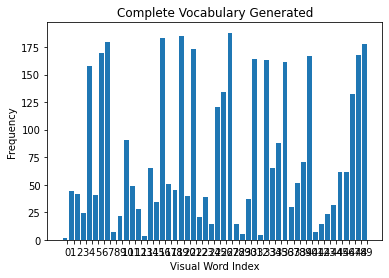

Features histogram plotted.
0.1 0.1
SVM fitted.
Training completed.
Test images path detected.
Test images classified.
Confusion matrix, without normalization
[[18  0  6  1  2  0  3]
 [ 0 26  4  0  0  0  0]
 [ 5  1 20  1  0  1  2]
 [ 4  3  2 15  3  3  0]
 [ 2  1  2  2 16  7  0]
 [ 2  0  0  3  7 18  0]
 [ 1  0  6  0  0  1 21]]
Normalized confusion matrix
[[0.6  0.   0.2  0.03 0.07 0.   0.1 ]
 [0.   0.87 0.13 0.   0.   0.   0.  ]
 [0.17 0.03 0.67 0.03 0.   0.03 0.07]
 [0.13 0.1  0.07 0.5  0.1  0.1  0.  ]
 [0.07 0.03 0.07 0.07 0.53 0.23 0.  ]
 [0.07 0.   0.   0.1  0.23 0.6  0.  ]
 [0.03 0.   0.21 0.   0.   0.03 0.72]]


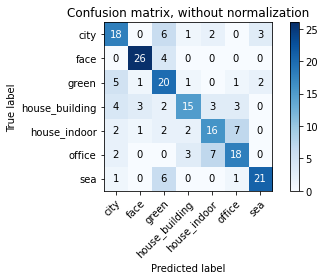

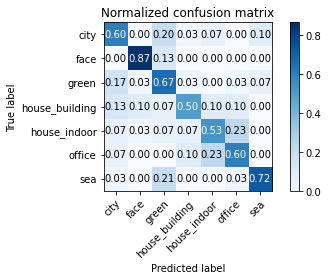

Confusion matrixes plotted.
accuracy score: 0.641
Accuracy calculated.
Execution done.


In [ ]:
execute('/content/drive/MyDrive/Colab Notebooks/VISIONS & PERSPECTIVE/10esercizio/Dataset/train', '/content/drive/MyDrive/Colab Notebooks/VISIONS & PERSPECTIVE/10esercizio/Dataset/test', 50, 'linear', 'sift')

examples on the 7 classes

In [ ]:
images_dir = '/content/drive/MyDrive/Colab Notebooks/VISIONS & PERSPECTIVE/10esercizio/imgSift'

In [ ]:
from skimage.io import imread

pathSampleA = '/content/drive/MyDrive/Colab Notebooks/VISIONS & PERSPECTIVE/10esercizio/Dataset/test/face/face_test-008.jpg'
sampleA = imread(pathSampleA)
pathSampleB = '/content/drive/MyDrive/Colab Notebooks/VISIONS & PERSPECTIVE/10esercizio/Dataset/test/sea/sea_test-003.jpg'
sampleB = imread(pathSampleB)
pathSampleC = '/content/drive/MyDrive/Colab Notebooks/VISIONS & PERSPECTIVE/10esercizio/Dataset/test/house_indoor/house_indoor_test-029.jpg'
sampleC = imread(pathSampleC)
pathSampleD = '/content/drive/MyDrive/Colab Notebooks/VISIONS & PERSPECTIVE/10esercizio/Dataset/test/green/green_test-014.jpg'
sampleD = imread(pathSampleD)
pathSampleE = '/content/drive/MyDrive/Colab Notebooks/VISIONS & PERSPECTIVE/10esercizio/Dataset/test/city/city_test-020.jpg'
sampleE = imread(pathSampleE)
pathSampleF = '/content/drive/MyDrive/Colab Notebooks/VISIONS & PERSPECTIVE/10esercizio/Dataset/test/house_building/house_building_test-028.jpg'
sampleF = imread(pathSampleF)
pathSampleG = '/content/drive/MyDrive/Colab Notebooks/VISIONS & PERSPECTIVE/10esercizio/Dataset/test/office/office_test-002.jpg'
sampleG = imread(pathSampleG)

sample = [sampleA, sampleB, sampleC, sampleD, sampleE, sampleF, sampleG]

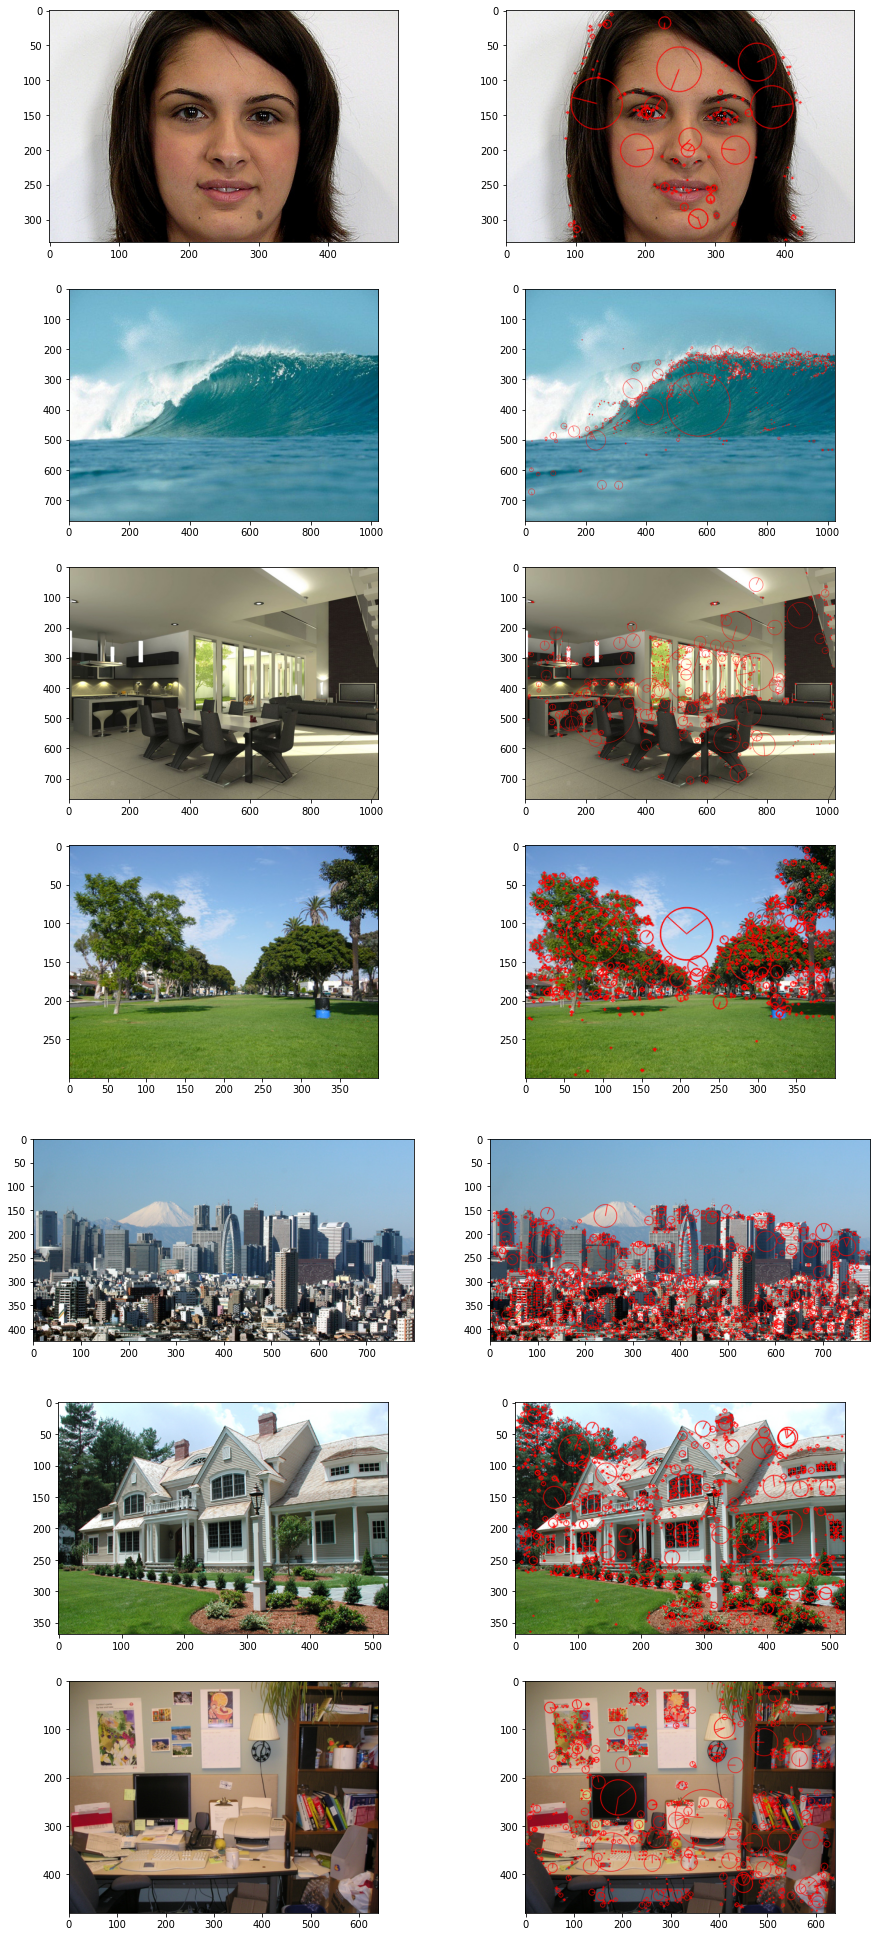

In [ ]:
sift = cv2.xfeatures2d.SIFT_create()

plt.figure(figsize=(15,35))
n=0

for s in range(len(sample)):
    #print(s)
    kp, des = sift.detectAndCompute(sample[s],None)
    out=cv2.drawKeypoints(sample[s], kp, None, (255,0,0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    n=n+1
    plt.subplot(7,2,n), plt.imshow(sample[s])
    n=n+1
    plt.subplot(7,2,n), plt.imshow(out)

###HARRIS###

Train images path detected.
Descriptors vstacked.
Descriptors clustered.
Images features extracted.
Train images normalized.


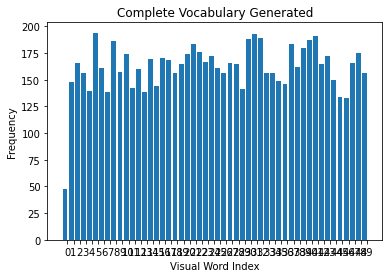

Features histogram plotted.
0.3 0.1
SVM fitted.
Training completed.
Test images path detected.
Test images classified.
Confusion matrix, without normalization
[[20  0  2  2  1  1  4]
 [ 0 25  0  3  0  2  0]
 [ 6  2 11  2  1  1  7]
 [ 7  0  8  9  2  3  1]
 [ 2  2  3  7  6  7  3]
 [ 3  3  2  5  2 11  4]
 [ 1  1  6  2  2  2 16]]
Normalized confusion matrix
[[0.67 0.   0.07 0.07 0.03 0.03 0.13]
 [0.   0.83 0.   0.1  0.   0.07 0.  ]
 [0.2  0.07 0.37 0.07 0.03 0.03 0.23]
 [0.23 0.   0.27 0.3  0.07 0.1  0.03]
 [0.07 0.07 0.1  0.23 0.2  0.23 0.1 ]
 [0.1  0.1  0.07 0.17 0.07 0.37 0.13]
 [0.03 0.03 0.2  0.07 0.07 0.07 0.53]]


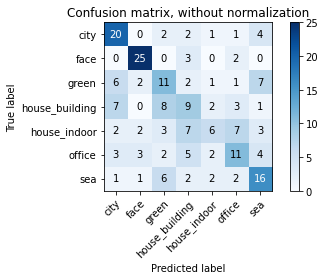

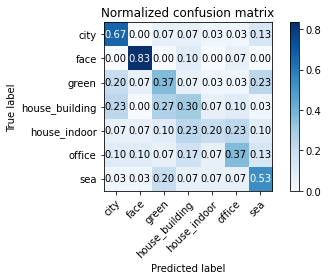

Confusion matrixes plotted.
accuracy score: 0.467
Accuracy calculated.
Execution done.


In [ ]:
execute('/content/drive/MyDrive/Colab Notebooks/VISIONS & PERSPECTIVE/10esercizio/Dataset/train', '/content/drive/MyDrive/Colab Notebooks/VISIONS & PERSPECTIVE/10esercizio/Dataset/test', 50, 'linear', 'harris')

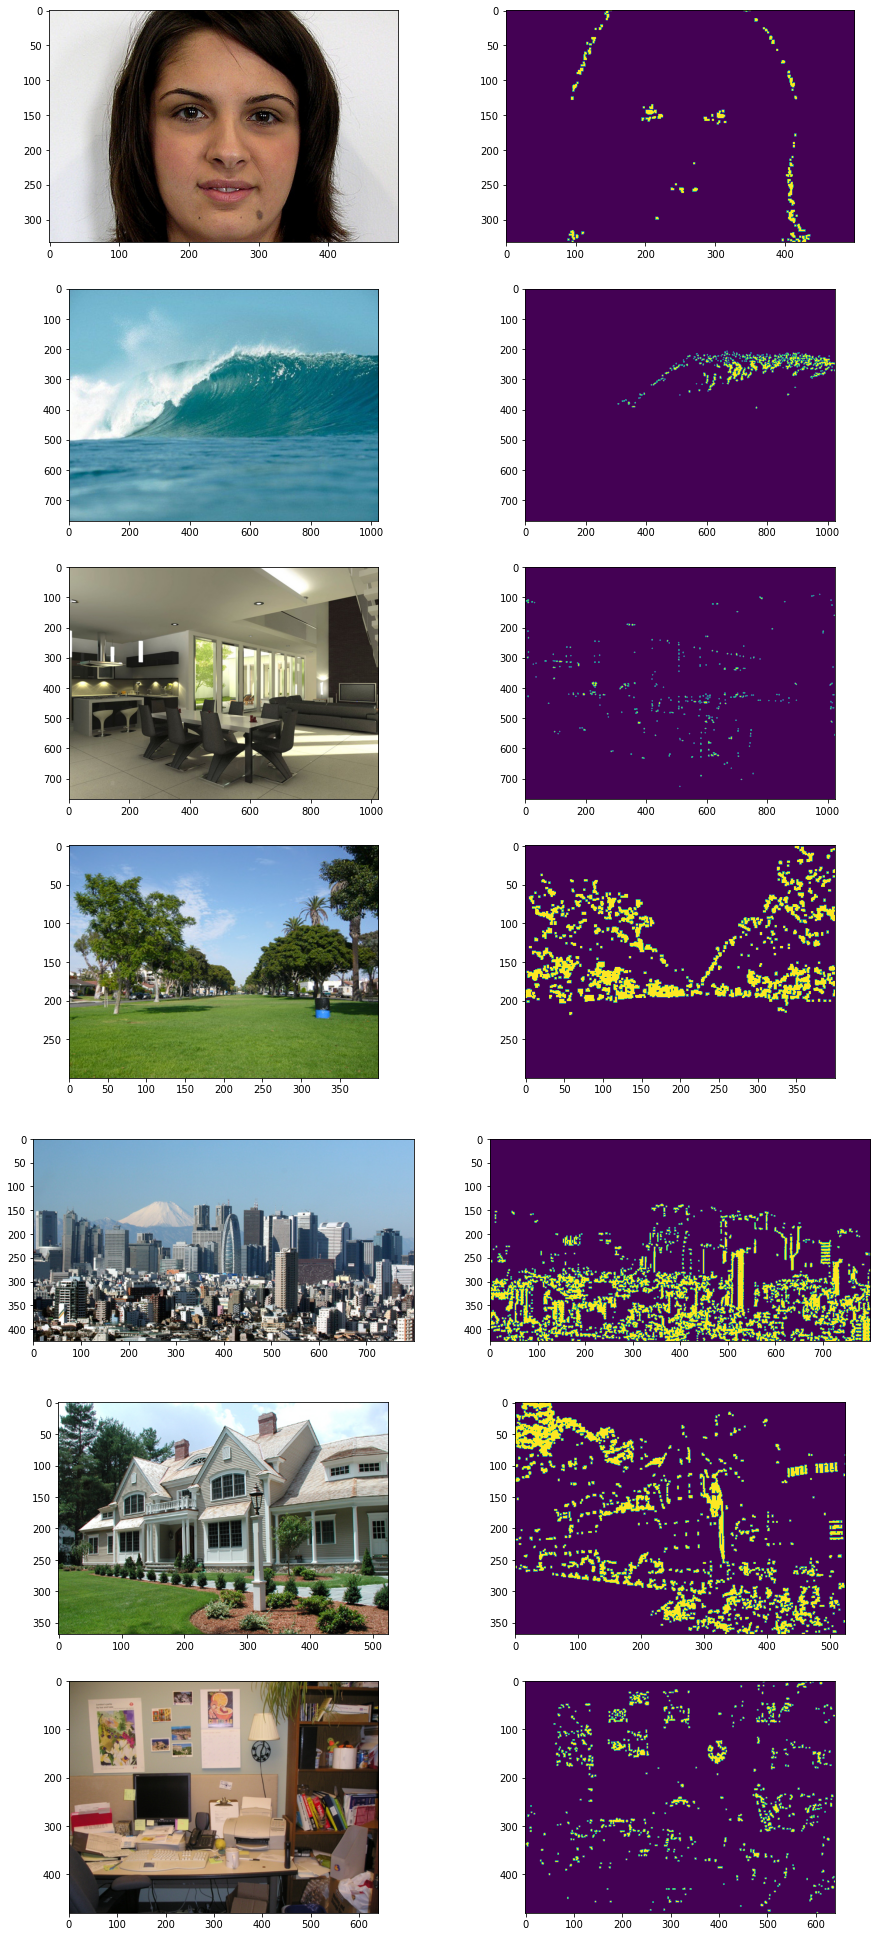

In [ ]:

plt.figure(figsize=(15,35))
n=0

for s in range(len(sample)):
    #print(s)
    gray = np.float32(rgb2gray(sample[s]))
    dst=cv2.cornerHarris(gray,2,3,0.04)
    dst = cv2.dilate(dst,None)
    dessi, des = cv2.threshold(dst,0.01*dst.max(),255,0)
    
    n=n+1
    plt.subplot(7,2,n), plt.imshow(sample[s])
    n=n+1
    plt.subplot(7,2,n), plt.imshow(des)


###SURF###

Train images path detected.
Descriptors vstacked.
Descriptors clustered.
Images features extracted.
Train images normalized.


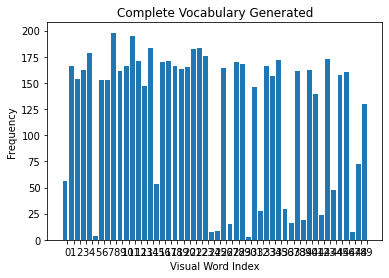

Features histogram plotted.
0.2 0.1
SVM fitted.
Training completed.
Test images path detected.
Test images classified.
Confusion matrix, without normalization
[[20  0  6  0  0  2  2]
 [ 0 25  2  0  1  0  2]
 [ 2  1 18  1  1  3  4]
 [ 2  0  5 16  4  3  0]
 [ 3  0  2  6  9 10  0]
 [ 3  0  2  1  2 22  0]
 [ 1  2  6  0  0  2 19]]
Normalized confusion matrix
[[0.67 0.   0.2  0.   0.   0.07 0.07]
 [0.   0.83 0.07 0.   0.03 0.   0.07]
 [0.07 0.03 0.6  0.03 0.03 0.1  0.13]
 [0.07 0.   0.17 0.53 0.13 0.1  0.  ]
 [0.1  0.   0.07 0.2  0.3  0.33 0.  ]
 [0.1  0.   0.07 0.03 0.07 0.73 0.  ]
 [0.03 0.07 0.2  0.   0.   0.07 0.63]]


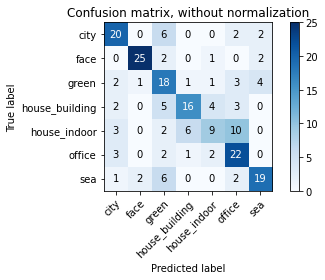

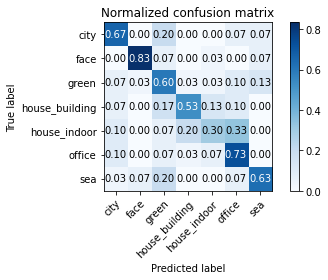

Confusion matrixes plotted.
accuracy score: 0.614
Accuracy calculated.
Execution done.


In [ ]:
execute('/content/drive/MyDrive/Colab Notebooks/VISIONS & PERSPECTIVE/10esercizio/Dataset/train', '/content/drive/MyDrive/Colab Notebooks/VISIONS & PERSPECTIVE/10esercizio/Dataset/test', 50, 'linear', 'surf')

292
521
1447
591
2714
1565
1216


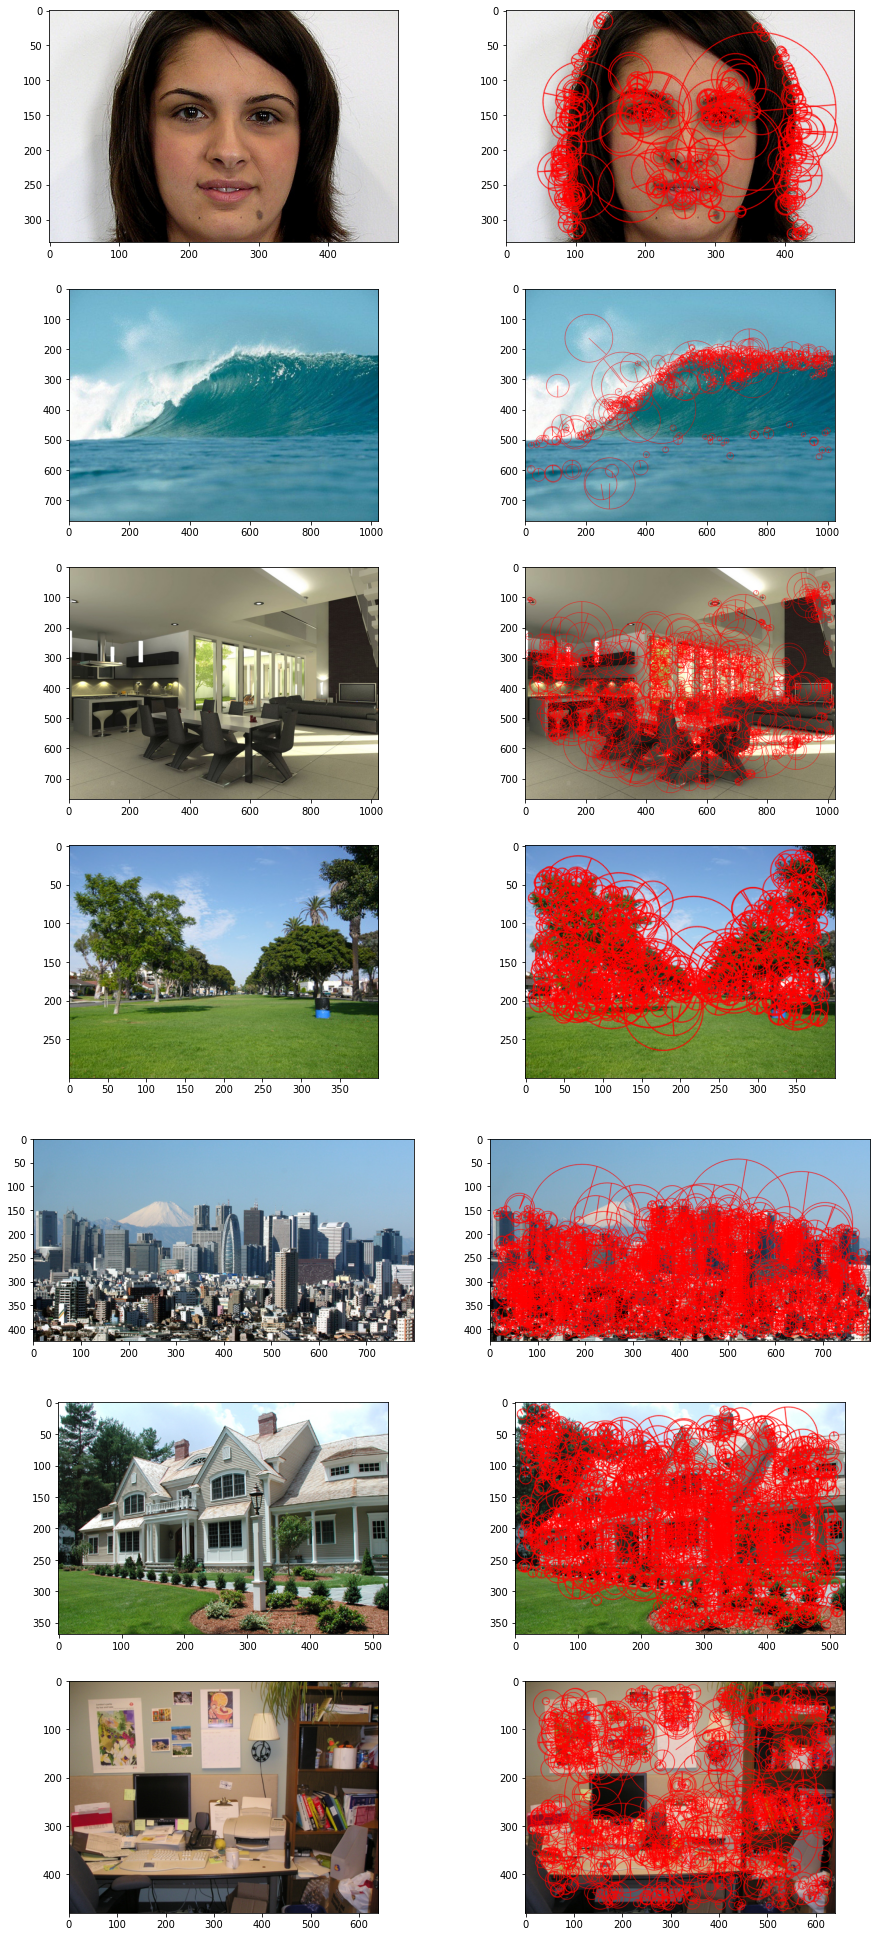

In [ ]:
surf = cv2.xfeatures2d.SURF_create(400)

plt.figure(figsize=(15,35))
n=0

for s in range(len(sample)):
    #print(s)
    kp, des = surf.detectAndCompute(sample[s],None)
    out=cv2.drawKeypoints(sample[s], kp, None, (255,0,0), 4)
    print(len(kp))
    n=n+1
    plt.subplot(7,2,n), plt.imshow(sample[s])
    n=n+1
    plt.subplot(7,2,n), plt.imshow(out)
